In [1]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import gdown
url = 'https://drive.google.com/file/d/14kTCUVe3OUjcsYYVh0f_8lrhn8csrh9M/view?usp=share_link'
output = 'forest2021.nc'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=14kTCUVe3OUjcsYYVh0f_8lrhn8csrh9M
To: /content/forest2021.nc
100%|██████████| 2.09G/2.09G [00:10<00:00, 191MB/s]


'forest2021.nc'

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Othercomputers/My MacBook Air/thesis/model'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# imports

In [4]:
import jax
print(jax.default_backend())
print(jax.device_count())

gpu
1


In [5]:
import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm
import pymc.sampling.jax as pmjax

import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [6]:
pm.__version__

'5.1.2'

In [7]:
RANDOM_SEED = 5434
rng = np.random.default_rng(RANDOM_SEED)

az.style.use('arviz-darkgrid')

# data

In [11]:
ds_train = xr.load_dataset('forest2021.nc').sel(
    x=slice(95, 100), 
    y=slice(55, 60), 
    time=slice('2021-06-01', '2021-07-31'))
ds_train

<xarray.Dataset>
Dimensions:      (time: 61, x: 51, y: 51)
Coordinates:
  * time         (time) datetime64[ns] 2021-06-01 2021-06-02 ... 2021-07-31
  * x            (x) float64 95.0 95.1 95.2 95.3 95.4 ... 99.7 99.8 99.9 100.0
  * y            (y) float64 55.0 55.1 55.2 55.3 55.4 ... 59.7 59.8 59.9 60.0
    spatial_ref  int64 0
Data variables:
    FWI          (time, y, x) float64 0.07822 0.09594 0.1031 ... 18.53 18.92
    counts       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 2.0 8.0
    forest_area  (y, x) float64 0.9869 0.9985 1.0 ... 0.9559 0.9337 0.9954
Attributes:
    Conventions:  CF-1.7

In [12]:
ds_test = xr.load_dataset('forest2021.nc').sel(
    x=slice(95, 100), 
    y=slice(55, 60), 
    time=slice('2021-08-01', '2021-08-31'))
ds_test

<xarray.Dataset>
Dimensions:      (time: 31, x: 51, y: 51)
Coordinates:
  * time         (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
  * x            (x) float64 95.0 95.1 95.2 95.3 95.4 ... 99.7 99.8 99.9 100.0
  * y            (y) float64 55.0 55.1 55.2 55.3 55.4 ... 59.7 59.8 59.9 60.0
    spatial_ref  int64 0
Data variables:
    FWI          (time, y, x) float64 0.4043 0.4149 0.4229 ... 3.922 3.737 3.707
    counts       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    forest_area  (y, x) float64 0.9869 0.9985 1.0 ... 0.9559 0.9337 0.9954
Attributes:
    Conventions:  CF-1.7

In [18]:
def train_test_split(train, test):
    X1_train = train.FWI.to_numpy().flatten()
    X1_test = test.FWI.to_numpy().flatten()

    X2_train = train.forest_area.to_numpy()
    X2_train = np.broadcast_to(X2_train, train.counts.shape).flatten()
    X2_test = test.forest_area.to_numpy()
    X2_test = np.broadcast_to(X2_test, test.counts.shape).flatten()

    y_train = train.counts.to_numpy().flatten().astype('int')
    y_test = test.counts.to_numpy().flatten().astype('int')

    train = pd.DataFrame({'X1': X1_train, 'X2': X2_train, 'y': y_train})
    train.dropna(inplace=True)

    test = pd.DataFrame({'X1': X1_test, 'X2': X2_test, 'y': y_test})
    test.dropna(inplace=True)

    return train, test

In [19]:
df_train, df_test = train_test_split(ds_train, ds_test)

# model

In [22]:
with pm.Model() as model:
    X1 = pm.MutableData('X1', df_train.X1)
    X2 = pm.MutableData('X2', df_train.X2)
    y = pm.MutableData('y', df_train.y)
    
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)

    mu = pm.math.exp(beta0 + beta1 * X1 + beta2 * X2)
    psi = pm.Beta('psi', alpha=1, beta=1)
    pm.ZeroInflatedPoisson('pred_zero', psi=psi, mu=mu, observed=y)

    idata = pmjax.sample_numpyro_nuts(chains=1, draws=5000, random_seed=RANDOM_SEED)

pm.summary(idata)

Compiling...
Compilation time =  0:00:43.536131
Sampling...


sample: 100%|██████████| 6000/6000 [09:29<00:00, 10.53it/s, 103 steps of size 2.64e-02. acc. prob=0.95]


Sampling time =  0:09:44.765870
Transforming variables...
Transformation time =  0:00:00.121321


Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-3.000,0.429,-3.810,-2.216,0.011,0.008,1585.0,1500.0,NaN
beta1,0.098,0.004,0.091,0.105,0.000,0.000,2675.0,2292.0,NaN
beta2,3.466,0.451,2.612,4.279,0.011,0.008,1570.0,1538.0,NaN
psi,0.005,0.000,0.005,0.005,0.000,0.000,2602.0,2422.0,NaN


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'psi'}>, <Axes: title={'center': 'psi'}>]],
      dtype=object)

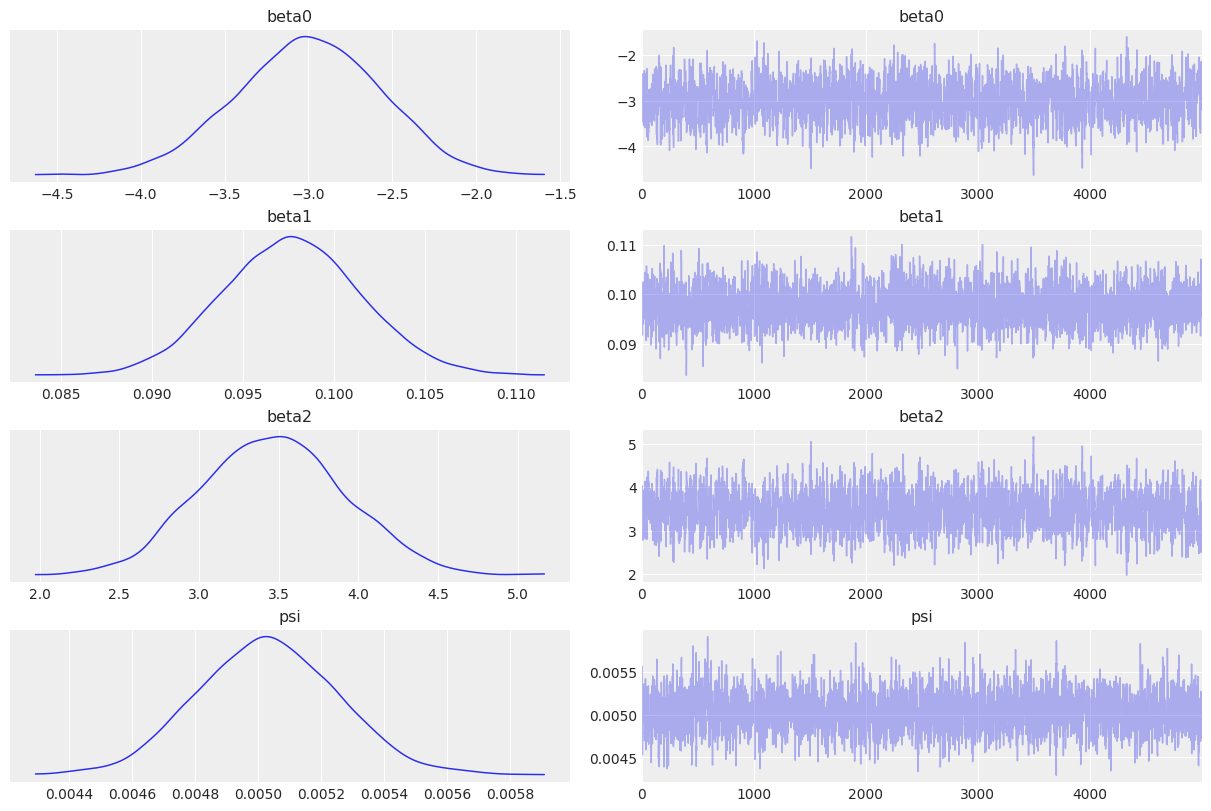

In [23]:
az.plot_trace(idata)

In [24]:
with model:
    pm.set_data({'X1': df_test.X1,
                 'X2': df_test.X2,
                 'y': df_test.y})
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=RANDOM_SEED)

In [25]:
idata.to_netcdf('{}/2021_idata_forest_zero.nc'.format(path))

'/content/drive/Othercomputers/My MacBook Air/thesis/model/2021_idata_forest_zero.nc'